In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.5,)
%matplotlib inline
fig_dir = "/Users/crankshaw/model-serving/clipper_paper/ModelServingPaper/nsdi_2017/fake-figs"

log_loc = os.path.abspath("/Users/crankshaw/clipper/experiments_logs/batch_wait_time/")

spark_results_files = []
sklearn_results_files = []

for name in os.listdir(log_loc):
    if "results" in name:
        if "spark" in name:
            spark_results_files.append(name)
        elif "sklearn" in name:
            sklearn_results_files.append(name)
print sklearn_results_files

['wait_time_0_sklearn_svm_160914-014455_results.json', 'wait_time_10_sklearn_svm_160914-021304_results.json', 'wait_time_1_sklearn_svm_160914-014743_results.json', 'wait_time_2_sklearn_svm_160914-015031_results.json', 'wait_time_3_sklearn_svm_160914-015319_results.json', 'wait_time_4_sklearn_svm_160914-015607_results.json', 'wait_time_5_sklearn_svm_160914-015855_results.json', 'wait_time_6_sklearn_svm_160914-020144_results.json', 'wait_time_7_sklearn_svm_160914-020435_results.json', 'wait_time_8_sklearn_svm_160914-020724_results.json', 'wait_time_9_sklearn_svm_160914-021013_results.json']


wait_time_0_spark_svm_160914-014330_results.json
wait_time_10_spark_svm_160914-021138_results.json
wait_time_1_spark_svm_160914-014619_results.json
wait_time_2_spark_svm_160914-014908_results.json
wait_time_3_spark_svm_160914-015155_results.json
wait_time_4_spark_svm_160914-015443_results.json
wait_time_5_spark_svm_160914-015732_results.json
wait_time_6_spark_svm_160914-020020_results.json
wait_time_7_spark_svm_160914-020308_results.json
wait_time_8_spark_svm_160914-020559_results.json
wait_time_9_spark_svm_160914-020849_results.json
wait_time_0_sklearn_svm_160914-014455_results.json
wait_time_10_sklearn_svm_160914-021304_results.json
wait_time_1_sklearn_svm_160914-014743_results.json
wait_time_2_sklearn_svm_160914-015031_results.json
wait_time_3_sklearn_svm_160914-015319_results.json
wait_time_4_sklearn_svm_160914-015607_results.json
wait_time_5_sklearn_svm_160914-015855_results.json
wait_time_6_sklearn_svm_160914-020144_results.json
wait_time_7_sklearn_svm_160914-020435_results.json


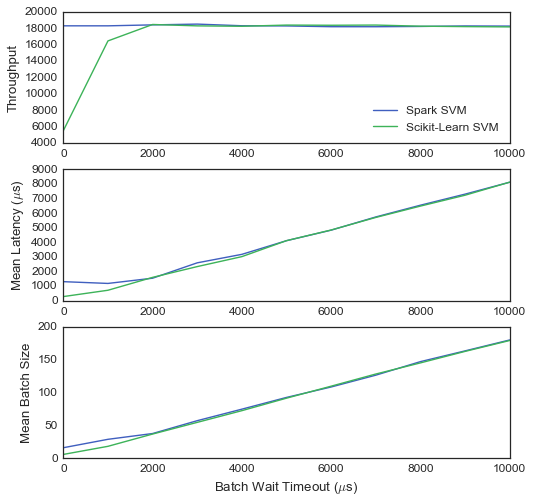

In [26]:

def extract_results(fname):
    with open(os.path.join(log_loc, fname), "r") as f:
        wait_time = int(fname.split("_")[2])*1000
        print fname
        res = json.load(f)
        model_latency = [m["mean"] for m in res["histograms"] if "model_latency" in m["name"]][0]
        model_batch_size = [m["mean"] for m in res["histograms"] if "model_batch_size" in m["name"]][0]
        model_thruput = [m["rate"] for m in res["meters"] if "model_thruput" in m["name"]][0]
#         if ensemble_size < 18:
#             df.loc[i] = [ensemble_size, clipper_mean, clipper_p99, blocking_mean, blocking_p99]
        return [wait_time, model_latency, model_batch_size, model_thruput]


sklearn_df = pd.DataFrame(columns=("wait_time", "model_latency", "model_batch_size", "model_thruput"))
spark_df = pd.DataFrame(columns=("wait_time", "model_latency", "model_batch_size", "model_thruput"))

for (i,r) in enumerate(spark_results_files):
    spark_df.loc[i] = extract_results(r)
for (i,r) in enumerate(sklearn_results_files):
    sklearn_df.loc[i] = extract_results(r)

spark_df.sort_values("wait_time", inplace=True)
sklearn_df.sort_values("wait_time", inplace=True)
colors = sns.color_palette("bright", n_colors=8, desat=.5)

fig, (ax_thru, ax_lat, ax_batch) = plt.subplots(nrows=3,figsize=(8,8))
ax_thru.plot(spark_df["wait_time"], spark_df["model_thruput"], label="Spark SVM", color=colors[0])
ax_thru.plot(sklearn_df["wait_time"], sklearn_df["model_thruput"], label="Scikit-Learn SVM", color=colors[1])
ax_thru.set_ylabel("Throughput")
ax_thru.legend(loc=0)

ax_lat.plot(spark_df["wait_time"], spark_df["model_latency"], label="Spark SVM", color=colors[0])
ax_lat.plot(sklearn_df["wait_time"], sklearn_df["model_latency"], label="Scikit-Learn SVM", color=colors[1])
ax_lat.set_ylabel("Mean Latency ($\mu$s)")

ax_batch.plot(spark_df["wait_time"], spark_df["model_batch_size"], label="Spark SVM", color=colors[0])
ax_batch.plot(sklearn_df["wait_time"], sklearn_df["model_batch_size"], label="Scikit-Learn SVM", color=colors[1])
ax_batch.set_ylabel("Mean Batch Size")
ax_batch.set_xlabel("Batch Wait Timeout ($\mu$s)")

